<a href="https://colab.research.google.com/github/keerthana-narra/csat_score_prediction_dl/blob/main/CSAT_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CSAT Scores**



##### **Project Type**    - Deep Learning
##### **Contribution**    -


Github link :

Project Documentation : [Documentation link]

Presentation : [Video link]

# **Problem Statement and Objective**


**Problem Overview**

This project focuses on predicting Customer Satisfaction (CSAT) scores using Deep Learning Artificial Neural Networks (ANN). In the context of e-commerce, understanding customer satisfaction through their interactions and feedback is crucial for enhancing service quality, customer retention, and overall business growth.


**Objective:**

 The goal of project is to leverage advanced neural network models, to accurately forecast CSAT scores based on a myriad of interaction-related features, providing actionable insights for service improvement.

# ***Let's Begin !***

## ***1. Know Your Data***

Before we diving into the project, our initial step is to familiarize ourselves with the dataset. Let's load the data and take a look.

### Import Libraries

In [ ]:
#!pip install nltk
#!python -m nltk.downloader vader_lexicon
#!pip install tensorflow tensorflow-hub
#!pip install category_encoders
#!pip install keras==2.12.0
#!pip uninstall tensorflow
#!pip install tensorflow==2.12.0


  Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached tensorboard-2.12.3-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached wrapt-1.14.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl.metadata (2.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn import preprocessing
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.stats import uniform, randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
import tensorflow.keras.backend as K


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Dataset Loading

In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load the dataset
df=pd.read_csv('/content/drive/MyDrive/Almabetter/Masters/Specilization/Module4/Capstone/eCommerce_Customer_support_data.csv')

In [ ]:
# Change column names to lowercase with underscores instead of spaces
df.columns = df.columns.str.lower().str.replace(' ', '_')

### Peek into data 👀

In [ ]:
#First 5 rows
df.head(2)

,unique_id,channel_name,category,sub-category,customer_remarks,order_id,order_date_time,issue_reported_at,issue_responded,survey_response_date,customer_city,product_category,item_price,connected_handling_time,agent_name,supervisor,manager,tenure_bucket,agent_shift,csat_score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5


In [ ]:
#Last 5 rows
df.tail(2)

,unique_id,channel_name,category,sub-category,customer_remarks,order_id,order_date_time,issue_reported_at,issue_responded,survey_response_date,customer_city,product_category,item_price,connected_handling_time,agent_name,supervisor,manager,tenure_bucket,agent_shift,csat_score
85905,707528ee-6873-4192-bfa9-a491f1c08ab5,Inbound,Feedback,UnProfessional Behaviour,NaN,a031ec28-0c5e-450e-95b2-592342c40bc4,NaN,31/08/2023 19:59,31/08/2023 20:00,31-Aug-23,NaN,NaN,NaN,NaN,Daniel Martin,Olivia Suzuki,Olivia Tan,>90,Morning,4
85906,07c7a878-0d5a-42e0-97ef-de59abec0238,Inbound,Returns,Reverse Pickup Enquiry,NaN,3230db30-f8da-4c44-8636-ec76d1d3d4f3,NaN,31/08/2023 23:36,31/08/2023 23:37,31-Aug-23,NaN,NaN,NaN,NaN,Elizabeth Guerra,Nathan Patel,Jennifer Nguyen,On Job Training,Evening,5


In [ ]:
# Dataset Rows & Columns
print(f'Shape of original dataframe:  {df.shape}')

Shape of original dataframe:  (85907, 20)


## ***2. Understanding Data & Preprocessing***

Moving forward to the next stage, our focus is on gaining a deeper understanding of the data and undertaking the initial preprocessing steps. These initial preprocessing efforts are crucial for enhancing the usability of the data in subsequent analyses.

### **Understanding Data**

In [ ]:
#Variables in the dataset
print(f'Variables in the dataset : {list(df.columns)}')

Variables in the dataset : ['unique_id', 'channel_name', 'category', 'sub-category', 'customer_remarks', 'order_id', 'order_date_time', 'issue_reported_at', 'issue_responded', 'survey_response_date', 'customer_city', 'product_category', 'item_price', 'connected_handling_time', 'agent_name', 'supervisor', 'manager', 'tenure_bucket', 'agent_shift', 'csat_score']


**Variables Description**

* **Unique id:** Unique identifier for each record (integer).
* **Channel name:** Name of the customer service channel (object/string).
* **Category:** Category of the interaction (object/string).
* **Sub-category:** Sub-category of the interaction (object/string).
* **Customer Remarks:** Feedback provided by the customer (object/string).
* **Order id:** Identifier for the order associated with the interaction (integer).
* **Order date time:** Date and time of the order (datetime).
* **Issue reported at:** Timestamp when the issue was reported (datetime).
* **Issue responded:** Timestamp when the issue was responded to (datetime).
* **Survey response date:** Date of the customer survey response (datetime).
* **Customer city:** City of the customer (object/string).
* **Product category:** Category of the product (object/string).
* **Item price:** Price of the item (float).
* **Connected handling time:** Time taken to handle the interaction (float).
* **Agent name:** Name of the customer service agent (object/string).
* **Supervisor:** Name of the supervisor (object/string).
* **Manager:** Name of the manager (object/string).
* **Tenure Bucket:** Bucket categorizing agent tenure (object/string).
* **Agent Shift:** Shift timing of the agent (object/string).
* **CSAT Score:** Customer Satisfaction (CSAT) score (integer).

In [ ]:
def summary(df):
    summry = pd.DataFrame(df.dtypes, columns=['data type'])
    summry['#missing'] = df.isnull().sum().values
    summry['Duplicate'] = df.duplicated().sum()
    summry['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summry['min'] = desc['min'].values
    summry['max'] = desc['max'].values
    summry['avg'] = desc['mean'].values
    summry['std dev'] = desc['std'].values
    summry['top value'] = desc['top'].values
    summry['Freq'] = desc['freq'].values

    return summry

In [ ]:
summary(df).style.set_caption(" Summary of the Data ").\
background_gradient(cmap='Blues', axis=0). \
set_properties(**{'border': '1.3px dotted', 'color': '', 'caption-side': 'left'})

,data type,#missing,Duplicate,#unique,min,max,avg,std dev,top value,Freq
unique_id,object,0,0,85907,nan,nan,nan,nan,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,1
channel_name,object,0,0,3,nan,nan,nan,nan,Inbound,68142
category,object,0,0,12,nan,nan,nan,nan,Returns,44097
sub-category,object,0,0,57,nan,nan,nan,nan,Reverse Pickup Enquiry,22389
customer_remarks,object,57165,0,18231,nan,nan,nan,nan,Good,1390
order_id,object,18232,0,67675,nan,nan,nan,nan,c27c9bb4-fa36-4140-9f1f-21009254ffdb,1
order_date_time,object,68693,0,13766,nan,nan,nan,nan,09/08/2023 11:55,7
issue_reported_at,object,0,0,30923,nan,nan,nan,nan,15/08/2023 10:59,13
issue_responded,object,0,0,30262,nan,nan,nan,nan,28/08/2023 00:00,3378
survey_response_date,object,0,0,31,nan,nan,nan,nan,28-Aug-23,3452


In [ ]:
def print_unique_counts(df, columns):
    for col in columns:
        unique_count = df[col].nunique()
        value_counts = df[col].value_counts()
        print(f"There are {unique_count} unique values and counts of each in {value_counts}\n")

# Columns to check uniques and values
columns_to_print = ['channel_name', 'category', 'manager', 'tenure_bucket', 'agent_shift']
print_unique_counts(df, columns_to_print)

There are 3 unique values and counts of each in channel_name
Inbound    68142
Outcall    14742
Email       3023
Name: count, dtype: int64

There are 12 unique values and counts of each in category
Returns               44097
Order Related         23215
Refund Related         4550
Product Queries        3692
Shopzilla Related      2792
Payments related       2327
Feedback               2294
Cancellation           2212
Offers & Cashback       480
Others                   99
App/website              84
Onboarding related       65
Name: count, dtype: int64

There are 6 unique values and counts of each in manager
John Smith         25261
Michael Lee        17600
Jennifer Nguyen    15897
Emily Chen         14062
William Kim         8568
Olivia Tan          4519
Name: count, dtype: int64

There are 5 unique values and counts of each in tenure_bucket
>90                30660
On Job Training    25523
31-60              11665
0-30               11318
61-90               6741
Name: count, dtype: 

In [ ]:
# Understanding categories and sub-categories
grouped_counts = df.groupby(['category', 'sub-category']).size().reset_index(name='count')
print(grouped_counts)

              category                      sub-category  count
0          App/website               App/website Related     10
1          App/website         Issues with Shopzilla App     74
2         Cancellation                        Not Needed   1920
3         Cancellation               Return cancellation    292
4             Feedback          UnProfessional Behaviour   2294
5    Offers & Cashback                  Affiliate Offers    183
6    Offers & Cashback                  Instant discount     78
7    Offers & Cashback                    Other Cashback    219
8   Onboarding related                Commission related      3
9   Onboarding related                 Seller onboarding     62
10       Order Related  Customer Requested Modifications    805
11       Order Related                           Delayed   7388
12       Order Related                   General Enquiry    252
13       Order Related                 Installation/demo   4116
14       Order Related                  

### ***Data Preprocessing***
This step before EDA helps us to understand data easily further
1. Drop the unique identifier and check for duplicates. As the unique identifier is a row generator.
2. Date type conversion.
3. Fill missing values in customer review column with ''


In [ ]:
# This function helps us to check and drop duplicates whenever required
def check_drop_duplications(df):
  if len(df[df.duplicated()]) > 0:
    print(f'Count of duplicate rows : {len(df[df.duplicated()])}')
    print(f'Dropping duplicates')
    df = df.drop_duplicates()
  else:
    print(f'There are no duplicates.')
  return df

In [ ]:
# Dropping identifiers
df = df.drop(columns = ['unique_id','order_id'])

In [ ]:
# Lets see if we have any duplicate rows
df = check_drop_duplications(df)

Count of duplicate rows : 9
Dropping duplicates


In [ ]:
# Converting datetime columns to same format
df['order_date_time'] = pd.to_datetime(df['order_date_time'])
df['issue_reported_at'] = pd.to_datetime(df['issue_reported_at'], format='mixed', dayfirst=True)
df['issue_responded'] = pd.to_datetime(df['issue_responded'], format='mixed', dayfirst=True)
df['survey_response_date'] = pd.to_datetime(df['survey_response_date'])

In [ ]:
#Fill NaN values with ''
df['customer_remarks'].fillna('neutral', inplace=True)

## ***3. Exploratory Data Analysis***

#### Chart-1 CSAT score distribution

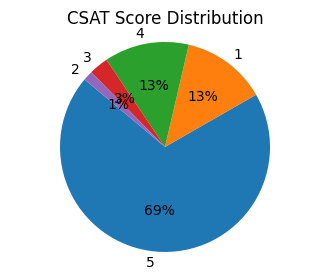

In [ ]:
# Pie chart for CSAT score distribution
csat_counts = df['csat_score'].value_counts()
plt.figure(figsize=(4, 3))
plt.pie(csat_counts, labels=csat_counts.index, autopct='%1.0f%%', startangle=140)
plt.title('CSAT Score Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#### Chart - 2 CSAT score distibution by category



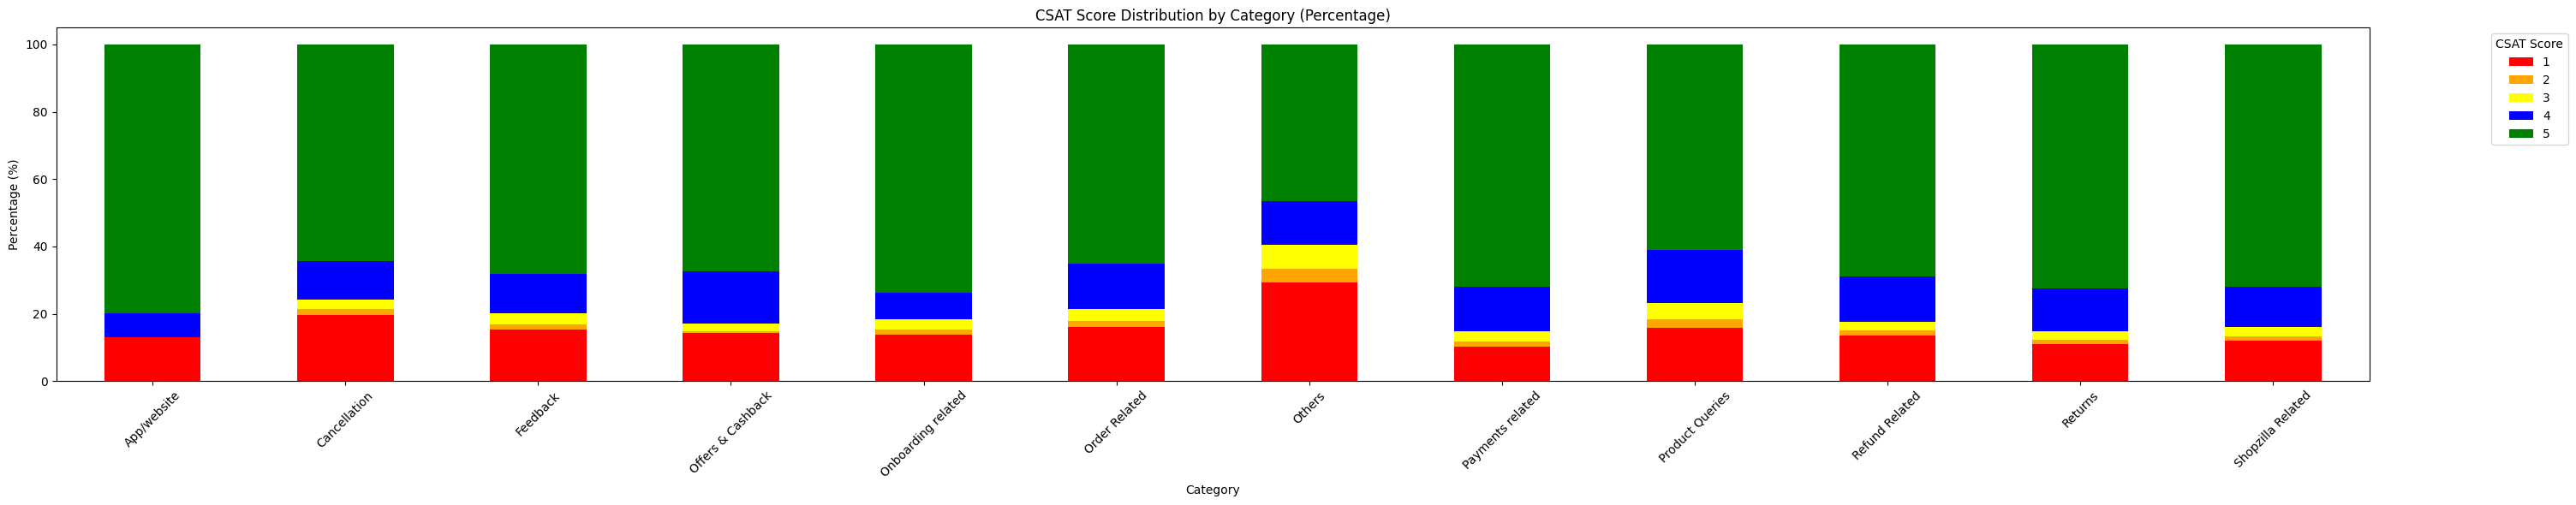

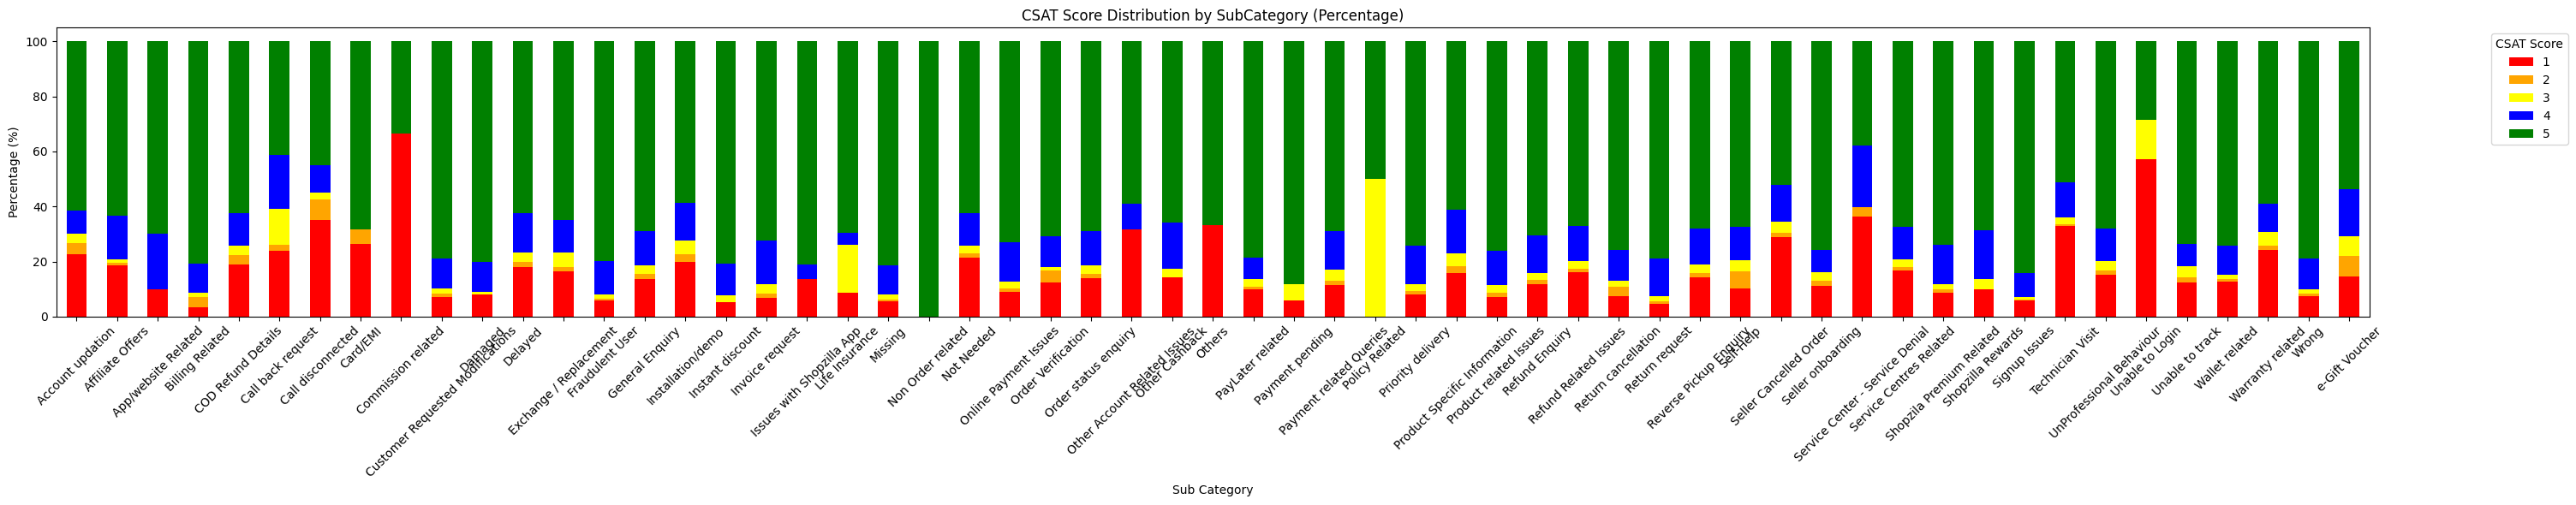

In [ ]:
# Calculate percentage of each CSAT score within each category
category_csat_counts = df.groupby(['category', 'csat_score']).size().unstack(fill_value=0)
category_csat_percentages = category_csat_counts.div(category_csat_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with percentages
custom_colors = {1: 'red', 5: 'green', 2: 'orange', 3: 'yellow', 4: 'blue'}
# Plot stacked bar chart with custom colors
category_csat_percentages.plot(kind='bar', stacked=True, figsize=(30, 6), color=[custom_colors[col] for col in category_csat_percentages.columns])
# Customize plot labels and legend
plt.title('CSAT Score Distribution by Category (Percentage)')
plt.xlabel('Category')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='CSAT Score', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

# Calculate percentage of each CSAT score within each category
category_csat_counts = df.groupby(['sub-category', 'csat_score']).size().unstack(fill_value=0)
category_csat_percentages = category_csat_counts.div(category_csat_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with custom colors
category_csat_percentages.plot(kind='bar', stacked=True, figsize=(30, 6), color=[custom_colors[col] for col in category_csat_percentages.columns])
# Customize plot labels and legend
plt.title('CSAT Score Distribution by SubCategory (Percentage)')
plt.xlabel('Sub Category')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='CSAT Score', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Highlight categories where CSAT score 1 > 20%
categories_high_csat1 = category_csat_percentages[category_csat_percentages[1] > 20].index

# Print categories where CSAT score 1 exceeds 20% along with percentages
print(f"Categories where CSAT score 1 exceeds 20%:")
for category in categories_high_csat1:
    percentage = category_csat_percentages.loc[category, 1]
    print(f"- {category}: {percentage:.2f}%")


Categories where CSAT score 1 exceeds 20%:
- Account updation: 22.67%
- Call back request: 23.91%
- Call disconnected: 35.00%
- Card/EMI: 26.32%
- Commission related: 66.67%
- Not Needed: 21.51%
- Other Account Related Issues: 31.82%
- Others: 33.33%
- Seller Cancelled Order: 28.80%
- Service Center - Service Denial: 36.21%
- Technician Visit: 32.80%
- Unable to Login: 57.14%
- Warranty related: 24.36%


#### Chart 3 - Sentiment score Distribution and CSAT score distribution with sentiment

In [ ]:
# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def calculate_sentiment(remark):
    scores = sid.polarity_scores(remark)
    compound_score = scores['compound']
    return compound_score


# Apply sentiment calculation
df['sentiment'] = df['customer_remarks'].apply(calculate_sentiment)

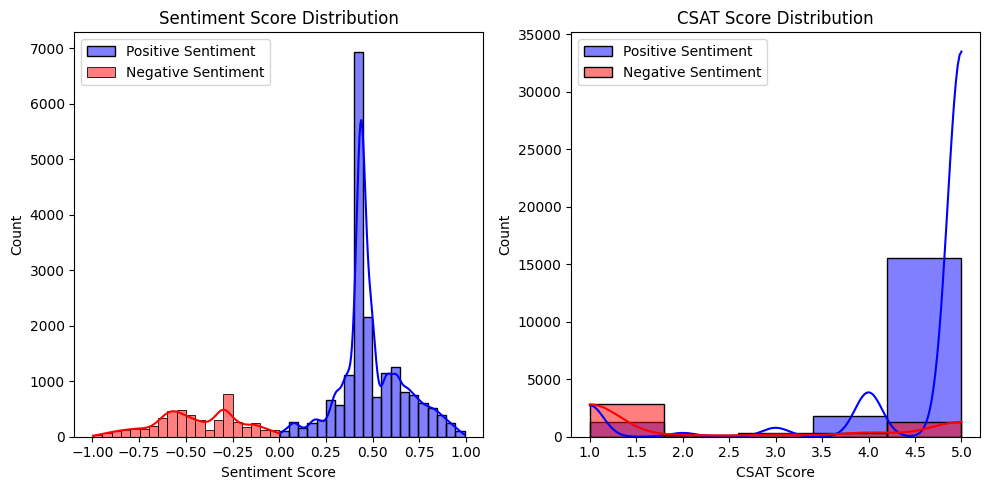

In [ ]:
# Set up figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot 1: Sentiment Score Distribution
sns.histplot(df[df['sentiment'] > 0]['sentiment'], bins=20, kde=True, color='blue', ax=axes[0], label='Positive Sentiment')
sns.histplot(df[df['sentiment'] < 0]['sentiment'], bins=20, kde=True, color='red', ax=axes[0], label='Negative Sentiment')
axes[0].set_title('Sentiment Score Distribution')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Count')
axes[0].legend()

# Plot 2: Sentiment Score with CSAT Distribution
# Positive sentiment scores
sns.histplot(df[df['sentiment'] > 0]['csat_score'], bins=5, kde=True, color='blue', alpha=0.5, ax=axes[1], label='Positive Sentiment')
# Negative sentiment scores
sns.histplot(df[df['sentiment'] < 0]['csat_score'], bins=5, kde=True, color='red', alpha=0.5, ax=axes[1], label='Negative Sentiment')
axes[1].set_title('CSAT Score Distribution')
axes[1].set_xlabel('CSAT Score')
axes[1].set_ylabel('Count')
axes[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

#### Chart 4 - Average CSAT Score by Issue Response Date

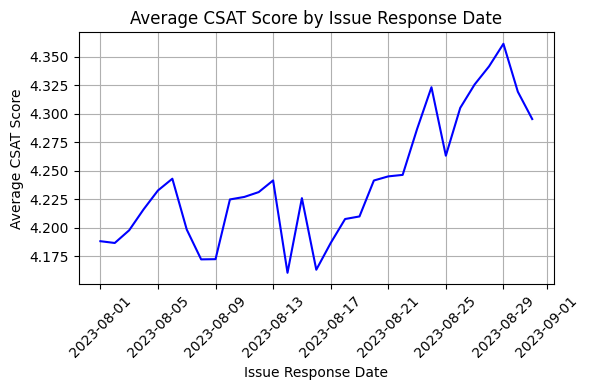

In [ ]:
# Aggregate CSAT scores by issue_responded date
csat_by_date = df.groupby(df['issue_responded'].dt.date)['csat_score'].mean()

# Plotting the line chart
plt.figure(figsize=(6, 4))
plt.plot(csat_by_date.index, csat_by_date.values, linestyle='-', color='blue')

plt.title('Average CSAT Score by Issue Response Date')
plt.xlabel('Issue Response Date')
plt.ylabel('Average CSAT Score')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

#### Chart - 5 CSAT score distribution with Manager

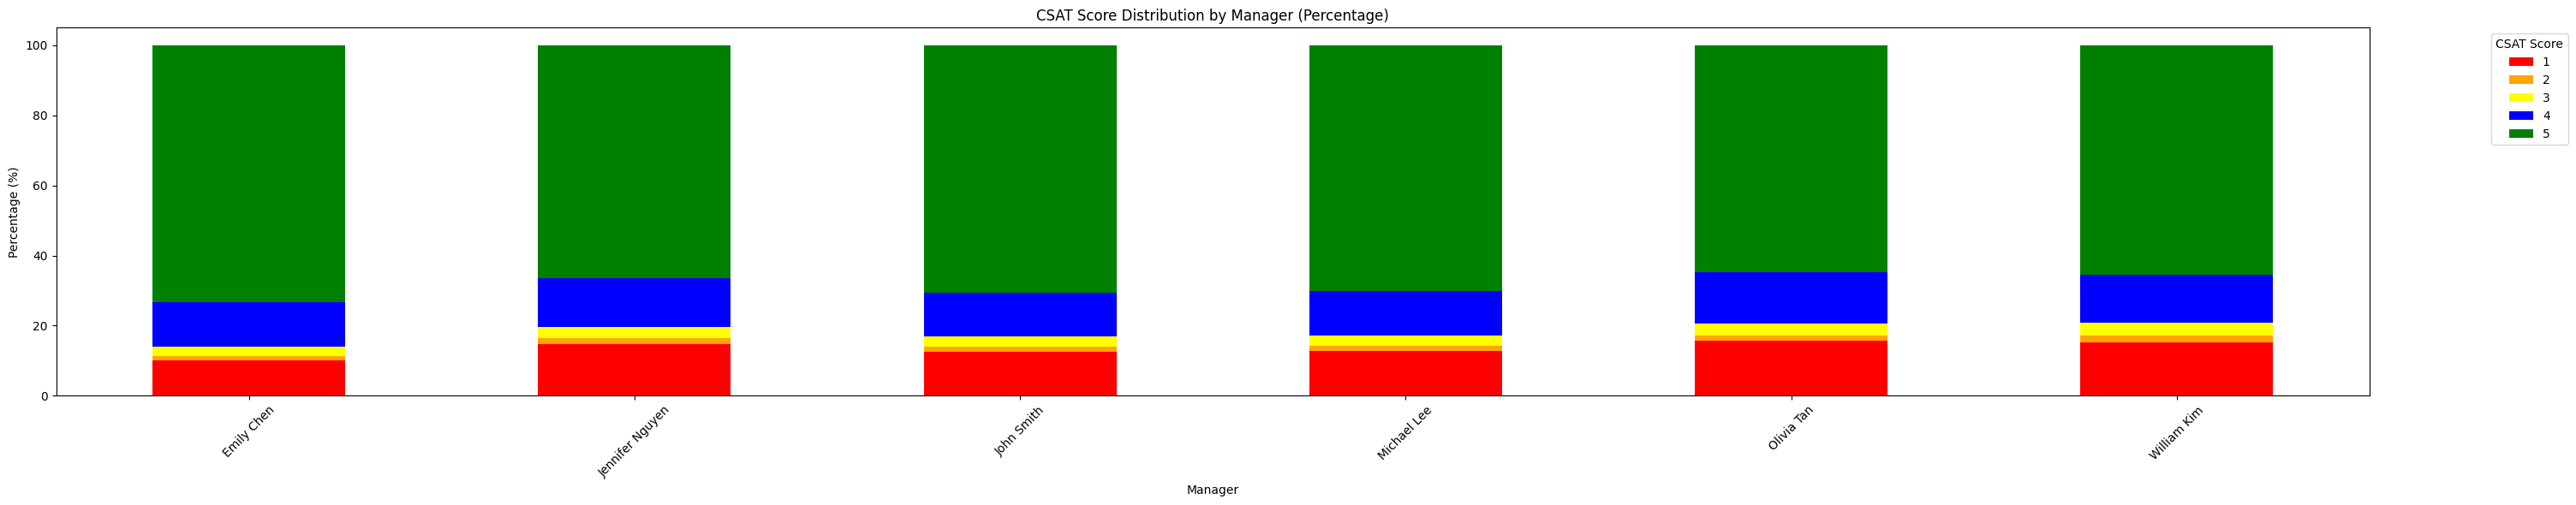

In [ ]:
# Calculate percentage of each CSAT score within each category
manager_csat_counts = df.groupby(['manager', 'csat_score']).size().unstack(fill_value=0)
manager_csat_percentages = manager_csat_counts.div(manager_csat_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with percentages
custom_colors = {1: 'red', 5: 'green', 2: 'orange', 3: 'yellow', 4: 'blue'}
# Plot stacked bar chart with custom colors
manager_csat_percentages.plot(kind='bar', stacked=True, figsize=(30, 6), color=[custom_colors[col] for col in manager_csat_percentages.columns])
# Customize plot labels and legend
plt.title('CSAT Score Distribution by Manager (Percentage)')
plt.xlabel('Manager')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.legend(title='CSAT Score', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

#### Chart 6 - Customer Reviews Word Cloud



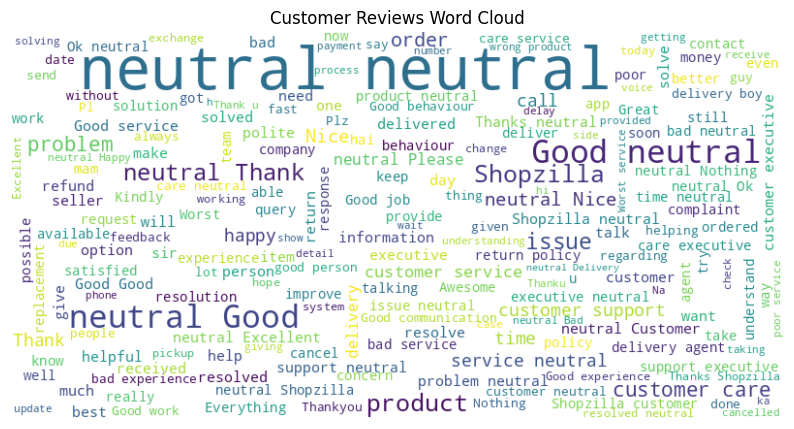

In [ ]:
from wordcloud import WordCloud

# Generate word cloud from customer reviews
text = ' '.join(df['customer_remarks'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Customer Reviews Word Cloud')
plt.axis('off')
plt.show()

### Overall Insights

## ***4. Data Transformation***

### 1. Feature Engineering

In [ ]:
# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Function to calculate sentiment score
def calculate_sentiment(remark):
    scores = sid.polarity_scores(remark)
    compound_score = scores['compound']
    return compound_score


# Apply sentiment calculation
df['sentiment'] = df['customer_remarks'].apply(calculate_sentiment)

In [ ]:
# Creating features based on issue_responded, issue_reported_at and survey_response_date
df['wait_response_time'] = (df['issue_responded'] - df['issue_reported_at']).dt.total_seconds()/60

# Note : survey_response date and issue_responded on same date for all rows.

# Calculate mean of Wait_response_time where it's greater than 0
mean_wait_response_time = df[df['wait_response_time'] > 0]['wait_response_time'].mean()
# Impute negative values with mean
df['wait_response_time'] = df['wait_response_time'].apply(lambda x: mean_wait_response_time if x < 0 else x)

### 2. Drop Unnecesary columns

In [ ]:
# Drop unnecessary columns and columns with very high percentage of nulls
# Drop columns which are not useful because of high number of missing values or high number of categories
drop_cols = ['order_date_time', 'customer_city',	'product_category',
           'item_price',	'connected_handling_time', 'customer_remarks', 'issue_reported_at',	'issue_responded',
             'survey_response_date']
df = df.drop(columns=drop_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85898 entries, 0 to 85906
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   channel_name        85898 non-null  object 
 1   category            85898 non-null  object 
 2   sub-category        85898 non-null  object 
 3   agent_name          85898 non-null  object 
 4   supervisor          85898 non-null  object 
 5   manager             85898 non-null  object 
 6   tenure_bucket       85898 non-null  object 
 7   agent_shift         85898 non-null  object 
 8   csat_score          85898 non-null  int64  
 9   sentiment           85898 non-null  float64
 10  wait_response_time  85898 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 7.9+ MB


### 3. Encoding

In [ ]:
# Columns to encode
columns_for_one_hot_encoding = ['channel_name', 'category', 'tenure_bucket', 'agent_shift']

# Perform one-hot encoding
df = pd.get_dummies(df, columns=columns_for_one_hot_encoding,dtype = int)

In [ ]:
# Perform target encoding
columns_for_target_encoding=['sub-category','agent_name','supervisor','manager']

for i in columns_for_target_encoding:
    scaler = TargetEncoder()
    df[i]=scaler.fit_transform(X=df[i],y=df['csat_score'])


### 4. Data Transformation

In [ ]:
# Normalizing Data
def min_max_normalization(df):
  scaler = MinMaxScaler()
  var = list(df.columns)
  features = df[var]
  df[var] = scaler.fit_transform(features.values)
  return df

In [ ]:
df = min_max_normalization(df)

In [ ]:
# Separate features (X) and target variable (y)
X = df.drop(columns=['csat_score'])
y = df['csat_score']

## ***5.Modelling & Evaluation***

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Assuming X_train and X_val are your feature matrices
input_dim = X_train.shape[1]

In [ ]:
# Model Architecture
# Input layer > Dropout > Hidden layer with relu activation > Dropout > Output layer
# Defined parameters -> neurons = 64, dropout rate = 0.2, learning rate = 0.001

def create_model(neurons=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(input_dim,), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['accuracy'])
    return model

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [ ]:
# Create the model with defined parameters
model_v0 = create_model()

# Train the model
history_v0 = model_v0.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model_v0.evaluate(X_val, y_val)
print(f'Mean Absolute Error: {accuracy}')
print(f'Mean Squared Error: {loss}')

Epoch 1/100
1933/1933 [==============================] - 4s 2ms/step - loss: 0.1272 - accuracy: 0.6857 - val_loss: 0.1070 - val_accuracy: 0.6987
Epoch 2/100
1933/1933 [==============================] - 5s 3ms/step - loss: 0.1069 - accuracy: 0.7036 - val_loss: 0.1063 - val_accuracy: 0.7071
Epoch 3/100
1933/1933 [==============================] - 7s 4ms/step - loss: 0.1018 - accuracy: 0.7100 - val_loss: 0.0994 - val_accuracy: 0.7113
Epoch 4/100
1933/1933 [==============================] - 8s 4ms/step - loss: 0.0995 - accuracy: 0.7123 - val_loss: 0.0986 - val_accuracy: 0.7118
Epoch 5/100
1933/1933 [==============================] - 5s 3ms/step - loss: 0.0989 - accuracy: 0.7122 - val_loss: 0.1002 - val_accuracy: 0.7124
Epoch 6/100
1933/1933 [==============================] - 4s 2ms/step - loss: 0.0983 - accuracy: 0.7126 - val_loss: 0.0990 - val_accuracy: 0.7117
Epoch 7/100
1933/1933 [==============================] - 5s 3ms/step - loss: 0.0982 - accuracy: 0.7126 - val_loss: 0.0984 - val_ac

In [ ]:
model_v0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2048      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________


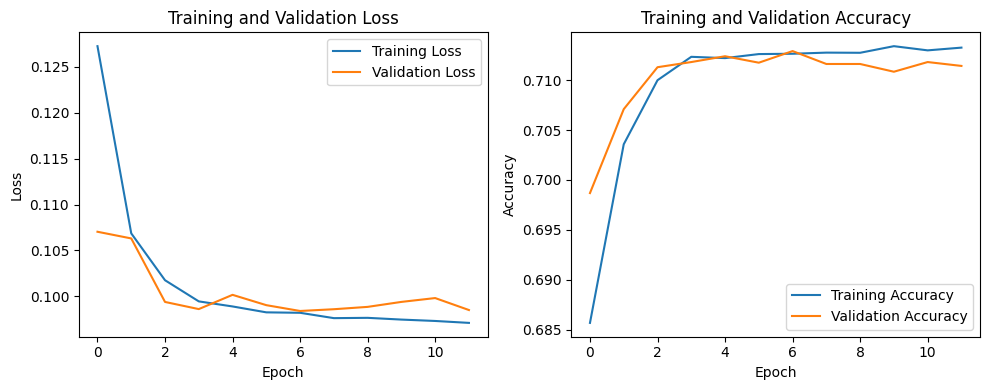

In [ ]:
# Plotting loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_v0.history['loss'], label='Training Loss')
plt.plot(history_v0.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history_v0.history['accuracy'], label='Training Accuracy')
plt.plot(history_v0.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Custom callback to log iterations and epochs
class PrintEpochCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch: {epoch}")

# Custom callback to store history
class StoreHistoryCallback(Callback):
    def on_train_begin(self, logs=None):
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)

# Instantiate the callbacks
print_epoch_callback = PrintEpochCallback()
store_history_callback = StoreHistoryCallback()

In [ ]:
# Wrap the model using KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the random search parameters with scaled uniform distributions
param_dist = {
    'neurons': randint(32, 129),  # Random integers between 32 and 128 inclusive
    'dropout_rate': uniform(0.1, 0.4),  # Uniform distribution from 0.1 to 0.5
    'batch_size': randint(16, 65),  # Random integers between 16 and 64 inclusive
    'epochs': randint(50, 151),  # Random integers between 50 and 150 inclusive
    'learning_rate': uniform(0.001, 0.009)  # Uniform distribution from 0.001 to 0.01
}

# Perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=2, cv=3, verbose=2, n_jobs=-1)

# Fit the model with random search
random_search_result = random_search.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping, print_epoch_callback,  store_history_callback])

# Print the best parameters and best score
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Restoring model weights from the end of the best epoch: 14.
Epoch: 18
Epoch 19: early stopping
Best: -0.097275 using {'batch_size': 49, 'dropout_rate': 0.3912850900985433, 'epochs': 141, 'learning_rate': 0.001247650821387084, 'neurons': 35}


In [ ]:
# Extract the best model
best_model = random_search_result.best_estimator_.model

# Evaluate the model to get the custom accuracy
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Loss: {loss}')
print(f'Custom Accuracy: {accuracy}')

# Print the model summary
best_model.summary()

484/484 [==============================] - 1s 2ms/step - loss: 0.0996 - accuracy: 0.7085
Loss: 0.09958913177251816
Custom Accuracy: 0.7085111737251282
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 35)                1120      
                                                                 
 dropout_10 (Dropout)        (None, 35)                0         
                                                                 
 dense_16 (Dense)            (None, 35)                1260      
                                                                 
 dropout_11 (Dropout)        (None, 35)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 36        
                                                                 
Total params: 2,416
Trainable param

In [ ]:
# Evaluate the model to get the accuracy
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Custom Accuracy: {accuracy}')

269/269 [==============================] - 0s 1ms/step - loss: 0.0929 - accuracy: 0.7198
Loss: 0.09289058297872543
Custom Accuracy: 0.7197904586791992


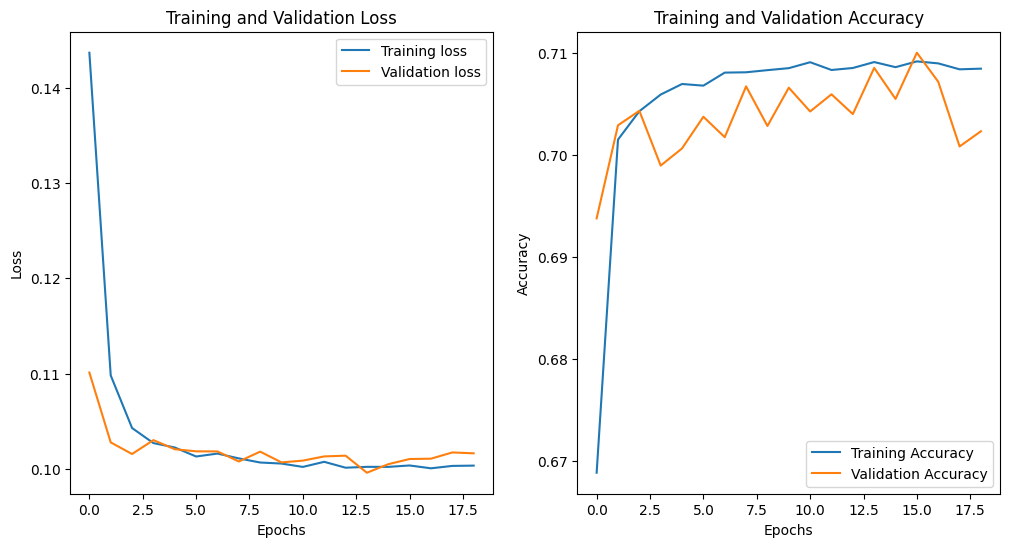

In [ ]:
# Plotting the training history
history_dict = store_history_callback.history

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training loss')
plt.plot(history_dict['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot the training and validation custom accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

#***6.Predictions***

In [ ]:
# Generate predictions for the validation set
y_pred = best_model.predict(X_test)

# Compare predictions to actual values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
comparison_df['Difference'] = comparison_df['Actual'] - comparison_df['Predicted']
comparison_df.head()

269/269 [==============================] - 0s 2ms/step


,Actual,Predicted,Difference
73293,1.0,0.846391,0.153609
44126,0.0,0.650141,-0.650141
19551,1.0,0.937512,0.062488
18341,1.0,0.952142,0.047858
75152,1.0,0.817246,0.182754


In [ ]:
min_y = 1  # Replace with your original min value of y
max_y = 5  # Replace with your original max value of y

# Reverse scaling using the formula
y_test_real = y_test * (max_y - min_y) + min_y
y_pred_real = (y_pred * (max_y - min_y) + min_y).round()

# Compare predictions to actual values
comparison_df = pd.DataFrame({'Actual': y_test_real, 'Predicted': y_pred_real.flatten()})
comparison_df['Difference'] = comparison_df['Actual'] - comparison_df['Predicted']
comparison_df.head()

,Actual,Predicted,Difference
73293,5.0,4.0,1.0
44126,1.0,4.0,-3.0
19551,5.0,5.0,0.0
18341,5.0,5.0,0.0
75152,5.0,4.0,1.0


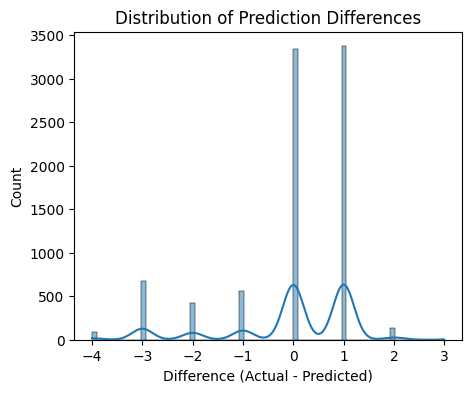

In [ ]:
# Distribution of the differences
plt.figure(figsize=(5, 4))
sns.histplot(comparison_df['Difference'], kde=True)
plt.xlabel('Difference (Actual - Predicted)')
plt.title('Distribution of Prediction Differences')
plt.show()

#**Summary**

# **Conclusion**